In [2]:
import math
import pandas as pd
import tqdm
import numpy as np

import torch
import torch.utils.data as data
import torch.optim as optim

from MINE import controller, datasets, losses, models

In [113]:
def experiment(optimizer, loss, batch_size=10):
    data_loader = data.DataLoader(
        datasets.IntegerPairDataset(
            number_of_cases=16,
            x_encoding='one_hot',
            y_encoding='one_hot',
            transform=datasets.TransformToTensor()
        ),
        batch_size=batch_size,
    )
    if loss == 'MINE':
        loss = losses.mine_loss()
    else:
        loss = losses.imine_loss(0.1)
    network = models.ConcatNet(16, 64)

    if optimizer == 'SGD':
        optimizer = optim.SGD(network.parameters(), lr=0.1)
    else:
        optimizer = optim.Adam(network.parameters(), lr=5e-4)

    agent = controller.MINEController(
        data_loader=data_loader, loss=loss, network=network, optimizer=optimizer
    )
    
    agent.to(0)
    agent.train()
    for i in tqdm.tqdm(range(3000)):
        agent.step()

    return agent

In [114]:
histories = {
    (opt, lss): experiment(opt, lss).history
    for opt in ('Adam', 'SGD')
    for lss in ('MINE', 'ReMINE')
}

100%|██████████| 3000/3000 [00:17<00:00, 168.54it/s]


In [115]:
def get_t(history, batch_size=10):
    t = []
    for i in range(0, len(history), batch_size):
        t.append(np.average(history.joint_value[i:i+batch_size]))
    return np.array(t)

def get_et(agent, batch_size=10):
    et = []
    for i in range(0, len(history), batch_size):
        et.append(np.log(np.average(np.exp(history.marginal_value[i:i+batch_size]))))
    return np.array(et)

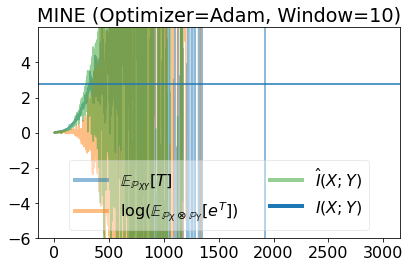

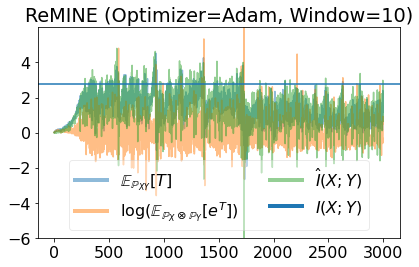

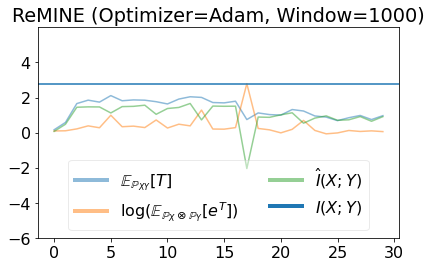

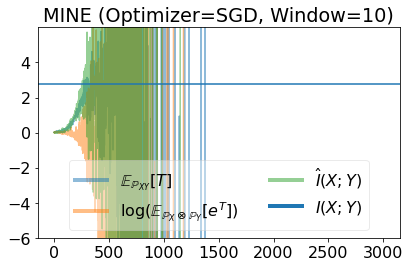

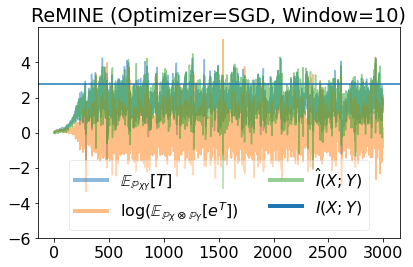

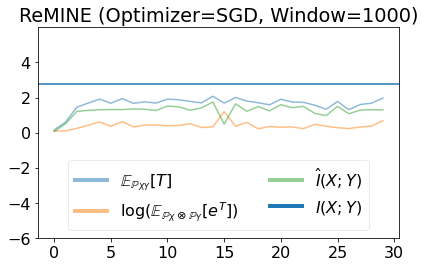

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rc('font', size=16)

for (opt, lss), history in histories.items():
    for bs in (10, 1000):
        if lss == 'MINE' and bs == 1000:
            continue
        plt.figure()
        t, et = get_t(history, bs), get_et(history, bs)
        mi = t - et
        plt.plot(t, alpha=0.5, label='$\mathbb{E}_{\mathbb{P}_{X Y}}[T]$')
        plt.plot(et, alpha=0.5, label='$\log(\mathbb{E}_{\mathbb{P}_X \otimes \mathbb{P}_Y}[e^{T}])$')
        plt.plot(mi, alpha=0.5, label='$\hat{I}(X; Y)$')
        plt.axhline(np.log(16), label='$I(X;Y)$')
        lg = plt.legend(loc='lower center', ncol=2, framealpha=0.4, fontsize='medium')
        plt.setp(lg.get_lines(), linewidth=4)
        plt.title(f'{lss} (Optimizer={opt}, Window={bs})')
        plt.ylim(-6, 6)
        plt.yticks([-6, -4, -2, 0, 2, 4])
        plt.tight_layout()
        plt.show()

<IPython.core.display.Javascript object>


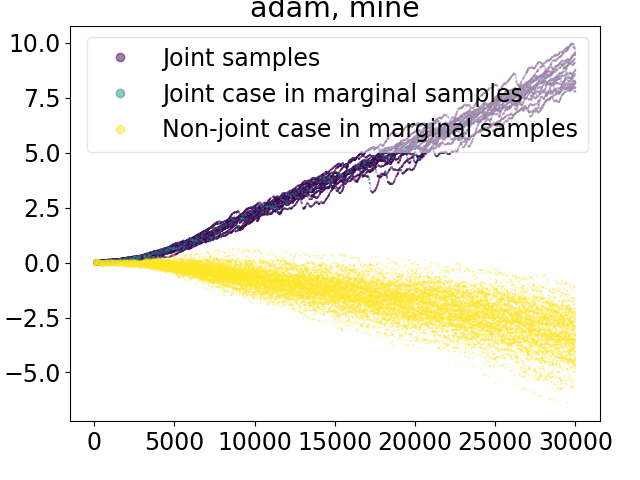

<IPython.core.display.Javascript object>


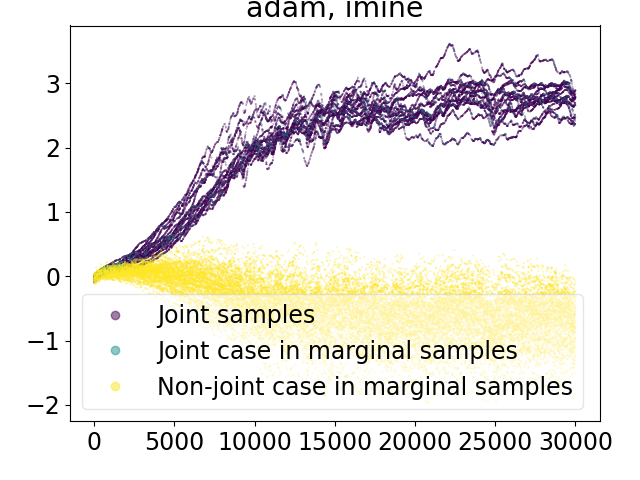

<IPython.core.display.Javascript object>


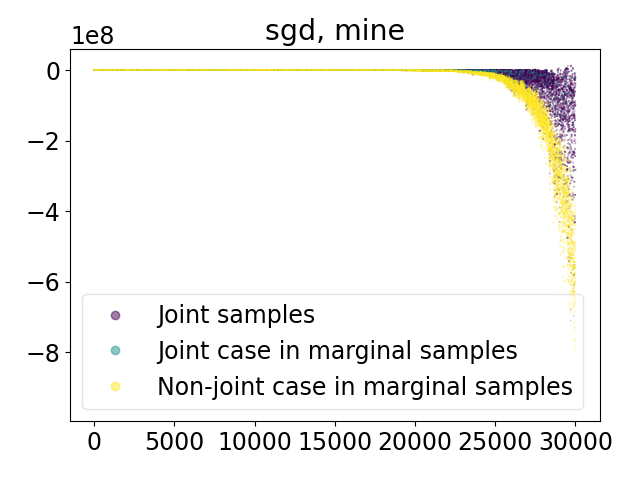

<IPython.core.display.Javascript object>


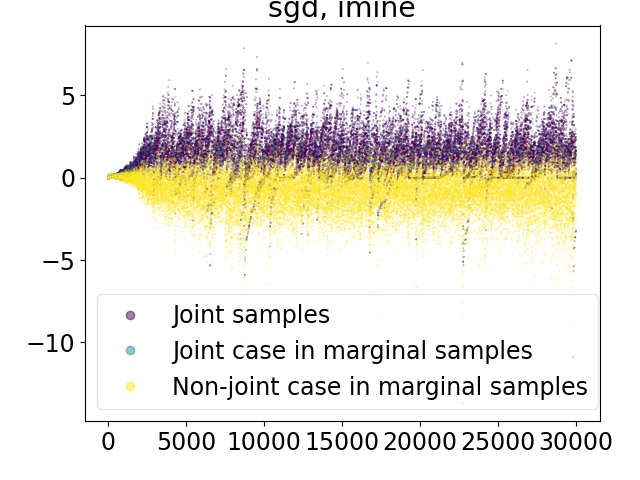

In [103]:
%matplotlib notebook
import matplotlib.pyplot as plt

matplotlib.rc('font', size=17)

for (opt, lss), history in histories.items():
    plt.figure()
    plt.subplot(1, 1, 1)
    sct = plt.scatter(
        list(range(len(history))) + list(range(len(history))),
        list(history.joint_value) + list(history.marginal_value),
        s=0.1, alpha=0.5,
        c=[1 for i in history.is_joint_case] + [2 if i else 3 for i in history.is_joint_case]
    )

#     plt.xticks(list(range(0, 35000, 5000)), [f'{i*50}k' for i in range(7)])
    plt.tight_layout()
    plt.legend(
        sct.legend_elements()[0],
        ['Joint samples', 'Joint case in marginal samples', 'Non-joint case in marginal samples'],
        framealpha=0.5
    )
    plt.title(f'{opt}, {lss}')
    plt.show()